In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from NetEmbs import *
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.figsize"] = [20,10]
set_font(16)

In [3]:
cur_path= "model/"+WORK_FOLDER[0]+WORK_FOLDER[1]

In [4]:
embs = pd.read_pickle(cur_path+"cache/Embeddings.pkl")

In [5]:
embs.head(5)

,ID,Emb,GroundTruth
0,1,"[-0.46218157, -0.4737277, 0.24686667, 0.7078327]",Purchase
1,3,"[-0.034228306, 0.35000387, 0.5635544, -0.7474839]",Sales 21 btw
2,4,"[-0.25864118, 0.40380427, -0.7663083, 0.4275727]",Cost of Sales
3,5,"[0.06989977, -0.5161656, -0.84813285, -0.09673...",Fixed Assets
4,6,"[0.3150946, 0.5739395, 0.59704685, 0.46351254]",Tax disbursement


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np


def plotVectors(df, title="Vectors", folder=""):
    plt.rc('axes', titlesize=18)  # fontsize of the x and y titles
    plt.rc('axes', labelsize=18)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
    plt.figure(figsize=(16, 8))
    t_ax = sns.heatmap(list(df["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
    frame1 = plt.gca()
    frame1.axes.set_xlabel('')
    frame1.axes.set_ylabel('Business processes')
    frame1.axes.xaxis.set_ticklabels([])
    ns = np.where(df.GroundTruth.values == None)[0][0]
    frame1.axes.yaxis.set_ticklabels(list(df["GroundTruth"].dropna().unique()), rotation='horizontal')
    frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns / 2 + it * (ns + 1) for it in range(8)]))
    plt.tight_layout()
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        postfix = ""
        if folder == "":
            postfix = "_emb_size" + str(len(df["Emb"].values[0])) + "samples_per_group" + str(ns)
        plt.savefig(folder + "img/" + title + postfix, dpi=140, pad_inches=0.01)

For group  Payroll Disbursement  is not enough samples...
For group  Purchase  is not enough samples...
For group  Tax disbursement  is not enough samples...


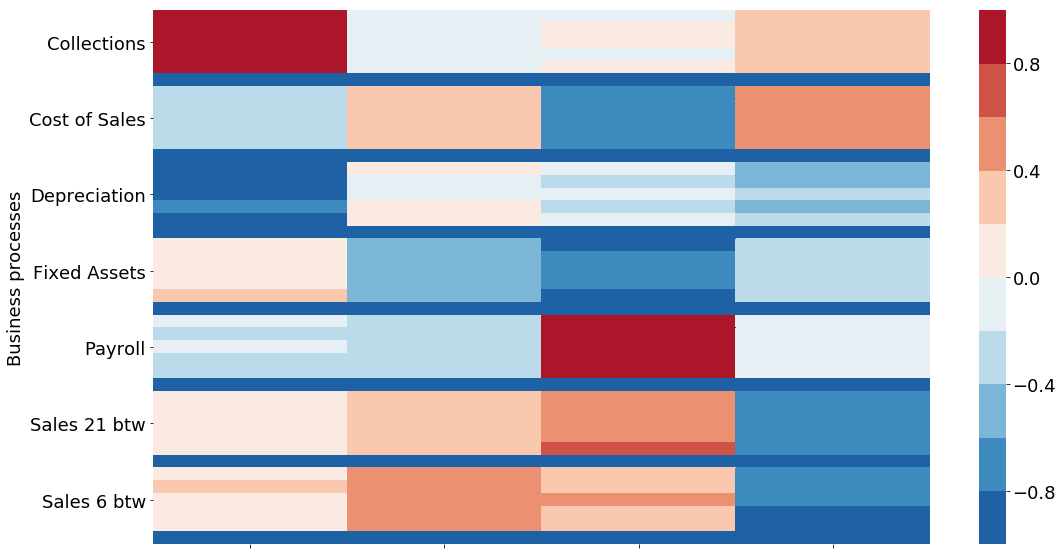

In [7]:
plotVectors(groupVectors(embs, how="mean", samples_per_group=5), title="prettyVectorsMean", folder=cur_path)

## K-Means

In [8]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
def plot_clusters(fsn_embs, n_cl = 6, title="KMean4", folder="", rand_state=1, manual=True):
    import os
    random.seed(rand_state)
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    if n_cl is None:
        n_cl = find_optimal_nClusters(fsn_embs, KMeans)
    tsne = TSNE(random_state=rand_state)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs.iloc[:, 1])))
    #     Clustering stuff
    print("First row of Data: \n", embdf.iloc[0].values)
    km = KMeans(n_clusters=n_cl)
    predicted_labels = km.fit_predict(embdf)
    centroids = km.cluster_centers_
    silhouette_avg = silhouette_score(embdf, predicted_labels)
    print("For n_clusters = ", n_cl,
              "The average silhouette_score is :", silhouette_avg)
#     TODO sync TSNE without clusters centers
    embdf = embdf.append(pd.DataFrame(centroids))
    embed_tsne = tsne.fit_transform(embdf)
    print(len(embed_tsne))
    fsn_embs["x"] = pd.Series(embed_tsne[:-n_cl, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:-n_cl, 1])
    import seaborn as sns
    markers = ["o", "v", "s"]
    cur_m=0
    if manual:
        plt.clf()
        n_gr = 0
        for name, group in fsn_embs.groupby("GroundTruth"):
            n_gr+=1
            if n_gr>10:
                cur_m = cur_m+1 if len(markers)-1>cur_m else 0
                n_gr=0
            plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], label=name)
#         sns.scatterplot(data=fsn_embs, x="x", y="y", hue="FA_Name", s=150)
        plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right", frameon=False, markerscale=1.4)
    else:
        fg = sns.FacetGrid(data=fsn_embs, hue='GroundTruth', aspect=1.61, height=6, legend_out=True)
        fg.map(pyplot.scatter, 'x', 'y')
        fg.add_legend()
    plt.scatter(embed_tsne[-n_cl:, 0], embed_tsne[-n_cl:, 1], marker='*', s=300, c='r', label='centroid')
    if title is not None and isinstance(title, str):
        plt.title("K-Means Clustering")
        plt.tight_layout()
        plt.savefig(folder+"img/" + title+str(n_cl), dpi=140, pad_inches=0.01)

def plot_tSNE(fsn_embs, title="tSNE", folder="", legend_title="GroundTruth", rand_state=1):
    import os
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    tsne = TSNE(random_state=rand_state)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs["Emb"])))
    embed_tsne = tsne.fit_transform(embdf)
    fsn_embs["x"] = pd.Series(embed_tsne[:, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:, 1])
    markers = ["o", "v", "s"]
    cur_m = 0
    plt.clf()
    n_gr = 0
    for name, group in fsn_embs.groupby(legend_title):
        n_gr += 1
        if n_gr > 3:
            cur_m = cur_m + 1 if len(markers) - 1 > cur_m else 0
            n_gr = 0
        cur_color = colors_list[group.groupby(legend_title).GroundTruth.agg(pd.Series.mode).values[0]]
        plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], c=cur_color, label=name)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right", frameon=False, markerscale=1.4)
    if legend_title == "GroundTruth":
        plt.title("Embeddings visualisation with t-SNE, Ground Truth")
    elif legend_title == "label":
        from sklearn.metrics import v_measure_score
        plt.title("Embeddings visualisation with t-SNE, predicted labels, V-Score is "+str(v_measure_score(cl_data.true_labels.values, cl_data.label.values).round(3)))

    if title is not None and isinstance(title, str):
        plt.tight_layout()
        postfix = ""
        if folder == "":
            postfix = "_" + "batch" + str(BATCH_SIZE) \
                      + "_emb" + str(EMBD_SIZE) \
                      + "_walks" + str(WALKS_PER_NODE) \
                      + "_TFsteps" + str(STEPS)
        plt.savefig(folder + "img/" + title + postfix, dpi=140, pad_inches=0.01)

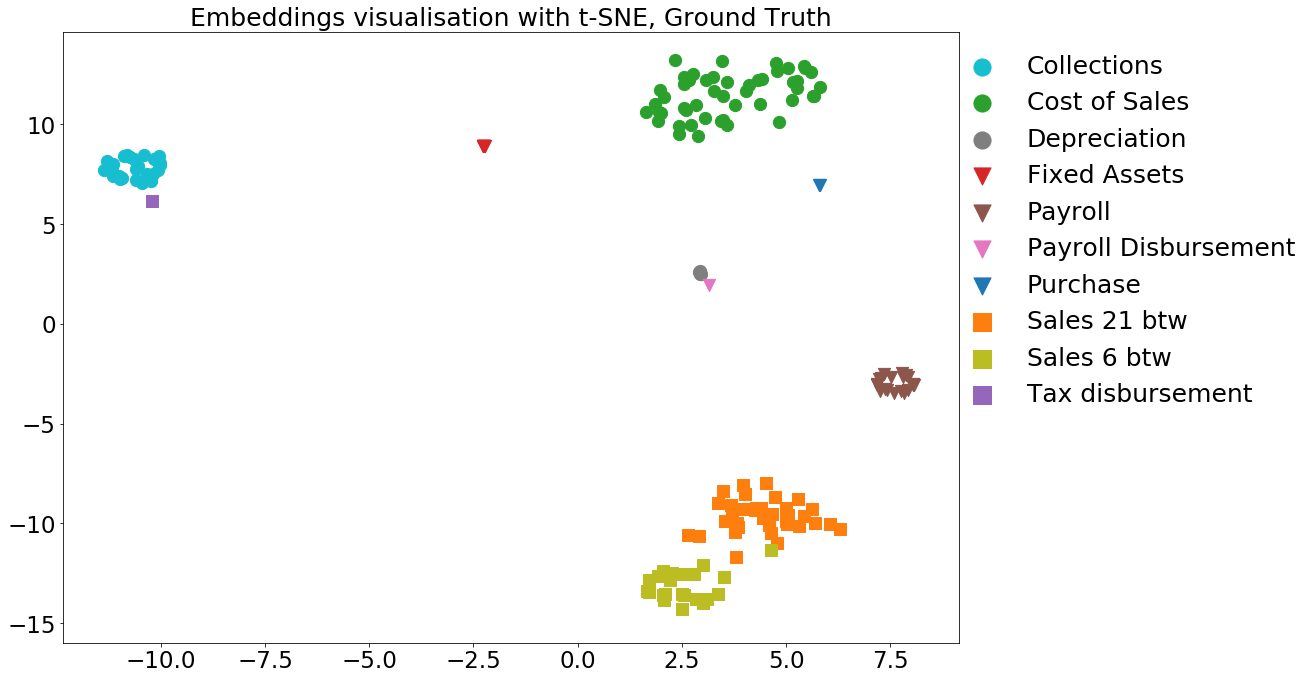

In [11]:
set_font(25)
plot_tSNE(embs, legend_title="GroundTruth", folder=cur_path)

In [ ]:
cl_data.head()

First row of Data: 
 [-0.46218157 -0.4737277   0.24686667  0.70783269]
Current clustering method is  <class 'sklearn.cluster.k_means_.KMeans'>
Optimal number of clusters is =  6 
The average silhouette_score is : 0.8041918971397432
First row of Data: 
 [-0.46218157 -0.4737277   0.24686667  0.70783269]
0.9047955098059146
First row of Data: 
 [-0.46218157 -0.4737277   0.24686667  0.70783269]
Current clustering method is  <class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>
Optimal number of clusters is =  8 
The average silhouette_score is : 0.8183576984605682
First row of Data: 
 [-0.46218157 -0.4737277   0.24686667  0.70783269]
0.9312501523750104


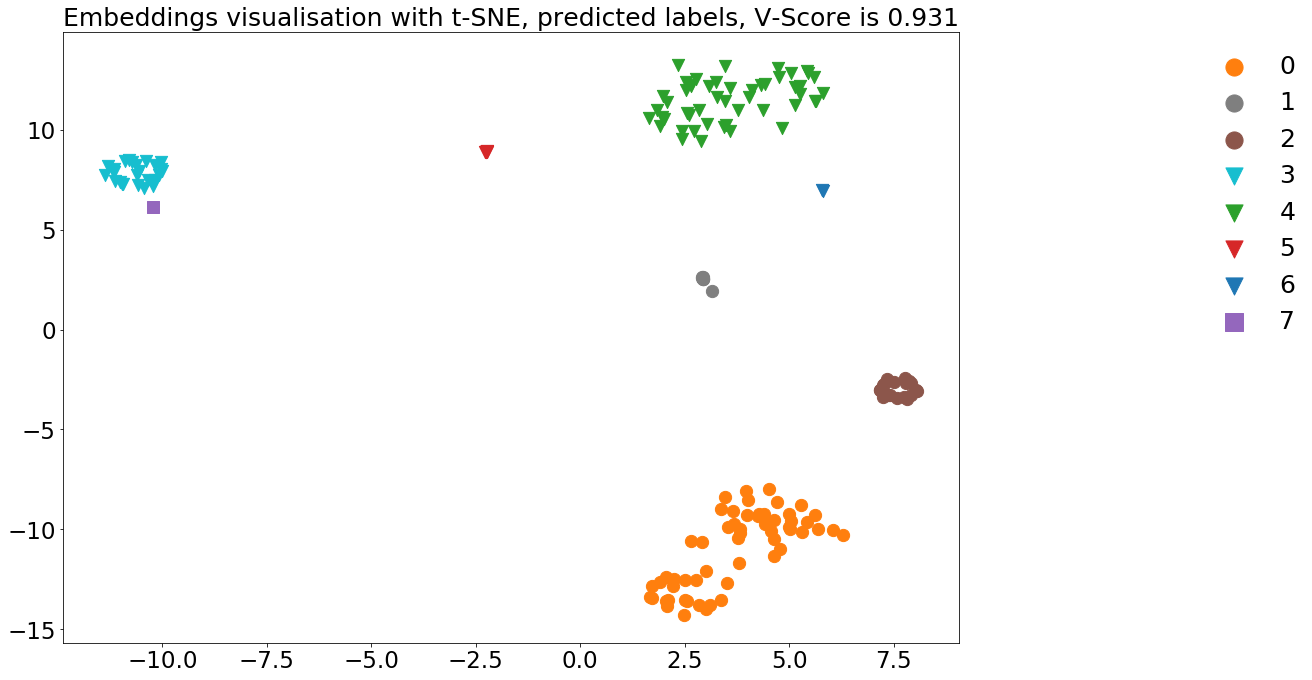

In [10]:
cl_data = cl_KMeans(embs, None)
str_labels = list(cl_data.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])
def getColors(c):
    cmap = cm.get_cmap('tab10', c)    # PiYG
    colors_list = list()
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        colors_list.append(matplotlib.colors.rgb2hex(rgb))
    return colors_list
colors_list = dict(zip(str_labels, getColors(len(str_labels))))
from sklearn.metrics import v_measure_score
print(v_measure_score(cl_data.true_labels.values, cl_data.label.values))
# plot_tSNE(cl_data, legend_title="GroundTruth", folder=cur_path, title="GT_out")
# plot_tSNE(cl_data, legend_title="label", folder=cur_path, title="KMean_outNone")
# agglomerative
cl_data = cl_Agglomerative(embs, None)
str_labels = list(cl_data.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])
from sklearn.metrics import v_measure_score
print(v_measure_score(cl_data.true_labels.values, cl_data.label.values))
plot_tSNE(cl_data, legend_title="label", folder=cur_path, title="Agglomerative_outNone")

In [ ]:
find_optimal_nClusters(embs, KMeans)

In [ ]:
find_optimal_nClusters(embs, AgglomerativeClustering)

## Agglomerative Clustering

In [ ]:
cl_data = cl_Agglomerative(embs, 9)
str_labels = list(cl_data.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])
from sklearn.metrics import v_measure_score
print(v_measure_score(cl_data.true_labels.values, cl_data.label.values))
plot_tSNE(cl_data, legend_title="label", folder=cur_path, title="Agglomerative")

In [ ]:
plt.rcParams['image.cmap']

In [ ]:
cmap = cm.get_cmap('viridis', 10)    # PiYG
colors_list = list()
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_list.append(matplotlib.colors.rgb2hex(rgb))

In [ ]:
colors_list

In [ ]:
cl_data.groupby(["label"]).GroundTruth.agg(pd.Series.mode)